In [1]:
%matplotlib inline
import numpy as np
seed = np.random.seed

In [2]:
# load utility classes/functions e.g., plot_decision_regions()
import urllib.request

urllib.request.urlretrieve(
    "https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/lab04lib.py",
    "lab04lib.py",
)

from lab04lib import *

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/"
    "machine-learning-databases/iris/iris.data",
    header=None,
)
df.columns = [
    "Sepal length",
    "Sepal width",
    "Petal length",
    "Petal width",
    "Class label",
]
display(df.head())

X = df[["Petal length", "Petal width"]].values
y = pd.factorize(df["Class label"])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print("# Training data points: %d" % X_train.shape[0])
print("# Testing data points: %d" % X_test.shape[0])
print("Class labels: %s" % np.unique(y))
print("X_train shape: %s. y_train shape: %s" % (X_train.shape, y_train.shape))
print("X_test shape: %s. y_test shape: %s" % (X_test.shape, y_test.shape))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Training data points: 80
# Testing data points: 20
Class labels: [-1  1]
X_train shape: (80, 2). y_train shape: (80,)
X_test shape: (20, 2). y_test shape: (20,)


In [4]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    batch_size : int
        Size of minibatches for stochastic gradient descent.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.

    """

    def __init__(
        self, eta=0.01, n_iter=50, batch_size=32, shuffle=True, random_state=1
    ):
        self.eta = eta
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            X_batches, y_batches = self._make_batches(X, y)
            for Xi, yi in zip(X_batches, y_batches):
                cost.append(self._update_weights(Xi, yi))
            avg_cost = sum(cost) / len(cost)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _make_batches(self, X, y):
        """Split data into batches"""
        X_batches = []
        y_batches = []
        for i in range(0, len(y), self.batch_size):
            j = min(i + self.batch_size, len(y))
            X_batches.append(X[i:j].reshape(-1, X.shape[1]))
            y_batches.append(y[i:j])
        return X_batches, y_batches

    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)

        # Cost function
        error = yi - output
        cost = 0.5 * (error**2).mean()

        # Update rule
        self.w_[1:] += self.eta * xi.T.dot(error)
        self.w_[0] += self.eta * error.sum()

        return cost

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            X_batches, y_batches = self._make_batches(X, y)
            for Xi, yi in zip(X_batches, y_batches):
                self._update_weights(Xi, yi)
        else:
            self._update_weights(X, y)
        return self

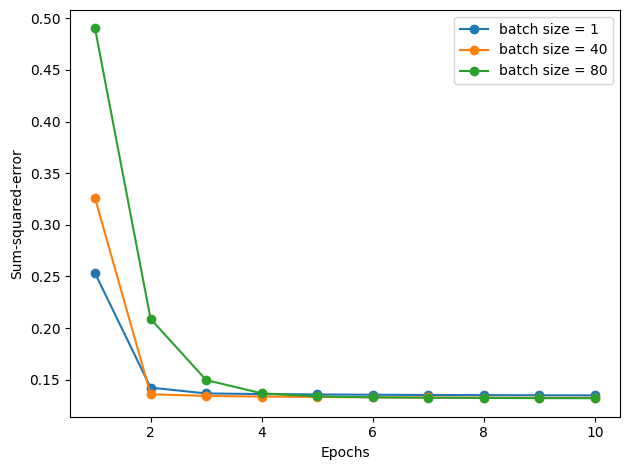

Accuracy (batch size = 1): 0.85
Accuracy (batch size = 40): 0.85
Accuracy (batch size = 80): 0.85


In [5]:
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score

batch_size_list = [1, 40, 80]
clf_list = []
for batch_size in batch_size_list:
    clf = AdalineSGD(
        n_iter=10,
        eta=0.01,
        batch_size=batch_size,
        shuffle=False,
        random_state=1,
    )
    clf.fit(X_train_std, y_train)
    clf_list.append(clf)

# Cost values
for i, clf in enumerate(clf_list):
    plt.plot(
        range(1, len(clf.cost_) + 1),
        clf.cost_,
        marker="o",
        label="batch size = %d" % batch_size_list[i],
    )
plt.xlabel("Epochs")
plt.ylabel("Sum-squared-error")
plt.legend(loc="upper right")

plt.tight_layout()
os.makedirs("./output/", exist_ok=True)
plt.savefig("./output/fig-adaline-sgd-cost.png", dpi=300)
plt.show()

# Testing accuracy
for i, clf in enumerate(clf_list):
    y_pred = clf.predict(X_test_std)
    print(
        "Accuracy (batch size = %d): %.2f"
        % (batch_size_list[i], accuracy_score(y_test, y_pred))
    )